# Import Library

In [148]:
import os
import zipfile
import io

import torch

import pandas as pd
import pydicom
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

from skimage.transform import resize
from typing import Dict, Tuple, List

# Config

In [149]:
DATASET_DIR = './dataset/MosMedData-CT-HEMORRHAGE-type VIII.zip'
DATASET_PATH = 'MosMedData-CT-HEMORRHAGE-type VIII'

IMG_SIZE = (512, 512)
BATCH_SIZE = 16
MAX_IMAGES_PER_SERIES = 512
START_IDX = 0

In [150]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read Image

In [151]:
def find_clinical_sheet(excel_file, keywords):
    """
    Finds the sheet containing clinical data in an Excel file.

    Parameters:
    excel_file (pd.ExcelFile): The Excel file object.
    keywords (list): List of keywords to identify the clinical sheet.

    Returns:
    str: The name of the sheet containing clinical data.

    Raises:
    ValueError: If no sheet with clinical data is found.
    """
    for sheet in excel_file.sheet_names:
        if any(keyword in sheet.lower() for keyword in keywords):
            return sheet
    
    raise ValueError('No clinical sheet found in the Excel file.')

def read_clinical_data(file_path):
    """
    Reads clinical data from an Excel file.

    Parameters:
    file_path (str): The path to the Excel file.

    Returns:
    pandas.DataFrame: A DataFrame containing the clinical data.

    Raises:
    ValueError: If no sheet with clinical data is found in the Excel file.
    """
    clinical_keywords = ['clinical', 'клинические']
    
    try:
        xls = pd.ExcelFile(file_path)
        clinical_sheet = find_clinical_sheet(xls, clinical_keywords)
        return pd.read_excel(xls, clinical_sheet)
    except ValueError as e:
        raise ValueError(f"Error reading clinical data: {str(e)}")

In [152]:
def preprocess_images(dicom_images, img_size=(512, 512)):
    """
    Preprocesses DICOM images for machine learning model input.

    Parameters:
    dicom_images (dict): A dictionary with a single key, where the value is a list of pydicom.dataset.FileDataset objects.
    img_size (tuple): Target image size (height, width). Default is (512, 512).

    Returns:
    numpy.ndarray: 4D array of preprocessed images (n_images, height, width, 3).
    """
    # Get the list of DICOM images from the dictionary
    images_list = list(dicom_images.values())[0]
    
    # Apply preprocess_single_image to each image in the list
    return np.array([preprocess_single_image(img, img_size) for img in images_list])

def preprocess_single_image(dicom_image, img_size):
    """
    Preprocesses a single DICOM image.

    Parameters:
    dicom_image (pydicom.dataset.FileDataset): DICOM image object.
    img_size (tuple): Target image size (height, width).

    Returns:
    numpy.ndarray: Preprocessed image as a 3D array (height, width, 3).
    """
    image_array = dicom_image.pixel_array
    normalized_image = normalize_image(image_array)
    resized_image = resize_image(normalized_image, img_size)
    return convert_to_rgb(resized_image)

def normalize_image(image):
    """
    Normalizes image pixel values to [0, 1] range.

    Parameters:
    image (numpy.ndarray): Input image array.

    Returns:
    numpy.ndarray: Normalized image array.
    """
    max_value = np.max(image)
    return image / max_value if max_value > 0 else np.zeros_like(image)

def resize_image(image, target_size):
    """
    Resizes image to target size using anti-aliasing.

    Parameters:
    image (numpy.ndarray): Input image array.
    target_size (tuple): Target image size (height, width).

    Returns:
    numpy.ndarray: Resized image array.
    """
    return resize(image, target_size, anti_aliasing=True)

def convert_to_rgb(image):
    """
    Converts grayscale image to RGB if necessary.

    Parameters:
    image (numpy.ndarray): Input image array.

    Returns:
    numpy.ndarray: RGB image array.
    """
    if len(image.shape) == 2:
        return np.stack((image,) * 3, axis=-1)
    return image

In [154]:
class BaseDatasetGenerator(Dataset):
    """
    Base class for generating datasets from zipped DICOM files and clinical data.

    This class handles the loading of DICOM images and clinical data from a nested
    zip file structure, providing methods to access individual studies and their
    associated labels.

    Attributes:
        studies_zip (str): Name of the zip file containing individual studies.
        dataset_dir (str): Path to the main dataset zip file.
        dataset_path (str): Path within the main zip to the dataset folder.
        start_idx (int): Starting index for processing studies.
        batch_size (int): Number of studies to process in a batch.
        max_images_per_series (int): Maximum number of images to process per series.
        clinical_data (pd.DataFrame): Loaded clinical data for all studies.
        study_uids (np.ndarray): Array of unique study UIDs.
        current_index (int): Current processing index.
    """

    def __init__(self, studies_zip: str, dataset_dir: str, dataset_path: str, 
                 start_idx: int = 0, batch_size: int = 100, max_images_per_series: int = 50):
        self.studies_zip = studies_zip
        self.dataset_dir = dataset_dir
        self.dataset_path = dataset_path
        self.start_idx = start_idx
        self.batch_size = batch_size
        self.max_images_per_series = max_images_per_series
        self.clinical_data = self._load_clinical_data()
        self.study_uids = self._get_study_uids()
        self.current_index = self.start_idx

    def _load_clinical_data(self) -> pd.DataFrame:
        """Load clinical data from the Excel file in the zip."""
        with zipfile.ZipFile(self.dataset_dir, 'r') as main_zip:
            studies_zip_path = os.path.join(self.dataset_path, self.studies_zip)
            with main_zip.open(studies_zip_path) as studies_file:
                with zipfile.ZipFile(io.BytesIO(studies_file.read())) as studies_zip:
                    xlsx_files = [f for f in studies_zip.namelist() if f.endswith('.xlsx')]
                    if len(xlsx_files) != 1:
                        raise ValueError("Expected exactly one XLSX file in the zip")
                    with studies_zip.open(xlsx_files[0]) as xlsx_file:
                        return pd.read_excel(io.BytesIO(xlsx_file.read()))

    def _get_study_uids(self) -> np.ndarray:
        """Extract unique study UIDs from the clinical data."""
        return self.clinical_data['study_uid'].unique()

    def __len__(self) -> int:
        """Return the total number of studies in the dataset."""
        return len(self.study_uids)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, Dict]:
        """
        Get the preprocessed images and labels for a specific study.

        Args:
            idx (int): Index of the study to retrieve.

        Returns:
            Tuple[np.ndarray, Dict]: Preprocessed images and labels for the study.
        """
        study_uid = self.study_uids[idx]
        dicom_series = self._load_dicom_images(study_uid)
        labels = self._get_labels(study_uid)
        processed_images = preprocess_images(dicom_series, img_size=(512, 512))
        return processed_images, labels

    def _load_dicom_images(self, study_uid: str) -> Dict[str, List[pydicom.dataset.FileDataset]]:
        """
        Load DICOM images for a specific study from the zip file.

        Args:
            study_uid (str): Unique identifier for the study.

        Returns:
            Dict[str, List[pydicom.dataset.FileDataset]]: Dictionary of DICOM images by series UID.
        """
        dicom_series = {}
        with zipfile.ZipFile(self.dataset_dir, 'r') as main_zip:
            studies_zip_path = os.path.join(self.dataset_path, self.studies_zip)
            with main_zip.open(studies_zip_path) as studies_file:
                with zipfile.ZipFile(io.BytesIO(studies_file.read())) as studies_zip:
                    inner_folder = os.path.splitext(self.studies_zip)[0]
                    study_path = f"{inner_folder}/{study_uid}/"
                    study_contents = [f for f in studies_zip.namelist() if f.startswith(study_path)]
                    subfolders = set(os.path.dirname(f) for f in study_contents if f.count('/') > study_path.count('/'))
                    
                    if subfolders:
                        subfolder_counts = {folder: sum(1 for f in study_contents if f.startswith(folder) and f.endswith('.dcm')) for folder in subfolders}
                        selected_folder = max(subfolder_counts, key=subfolder_counts.get)
                        study_files = [f for f in study_contents if f.startswith(selected_folder) and f.endswith('.dcm')]
                    else:
                        study_files = [f for f in study_contents if f.endswith('.dcm')]
                    
                    for file_path in study_files:
                        with studies_zip.open(file_path) as dicom_file:
                            dicom_image = pydicom.dcmread(io.BytesIO(dicom_file.read()), force=True)
                            series_uid = dicom_image.SeriesInstanceUID
                            if series_uid not in dicom_series:
                                dicom_series[series_uid] = []
                            dicom_series[series_uid].append(dicom_image)
        return dicom_series

    def _get_labels(self, study_uid: str) -> Dict:
        """
        Get labels for a specific study.

        Args:
            study_uid (str): Unique identifier for the study.

        Returns:
            Dict: Labels for the study, or None if not found.
        """
        study_clinical_data = self.clinical_data[self.clinical_data['study_uid'] == study_uid]
        return study_clinical_data.iloc[0].to_dict() if not study_clinical_data.empty else None


class TrainDatasetGenerator(BaseDatasetGenerator):
    """
    Dataset generator for training data.

    This class inherits from BaseDatasetGenerator and can be extended with
    training-specific functionality as needed.
    """

    def __init__(self, studies_zip: str, dataset_dir: str, dataset_path: str, 
                 start_idx: int = 0, batch_size: int = 100, max_images_per_series: int = 50):
        super().__init__(studies_zip, dataset_dir, dataset_path, start_idx, batch_size, max_images_per_series)
        # Additional initialization for training dataset if needed


class TestDatasetGenerator(BaseDatasetGenerator):
    """
    Dataset generator for test data.

    This class inherits from BaseDatasetGenerator and can be extended with
    test-specific functionality as needed.
    """

    def __init__(self, studies_zip: str, dataset_dir: str, dataset_path: str, 
                 start_idx: int = 0, batch_size: int = 100, max_images_per_series: int = 50):
        super().__init__(studies_zip, dataset_dir, dataset_path, start_idx, batch_size, max_images_per_series)
        # Additional initialization for test dataset if needed


In [155]:
# Example usage
studies_zip = '400_500_studies.zip'

train_dataset = TrainDatasetGenerator(studies_zip, dataset_dir=DATASET_DIR, dataset_path=DATASET_PATH)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [156]:
def plot_dicom_images(images, labels, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.set_title(f"Image {i+1}")
            # ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("Labels:")
    for key, value in labels.items():
        print(f"{key}: {value}")


/home/hskha23/miniconda3/envs/tf/lib/python3.10/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.04140300061500130406141409051107'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


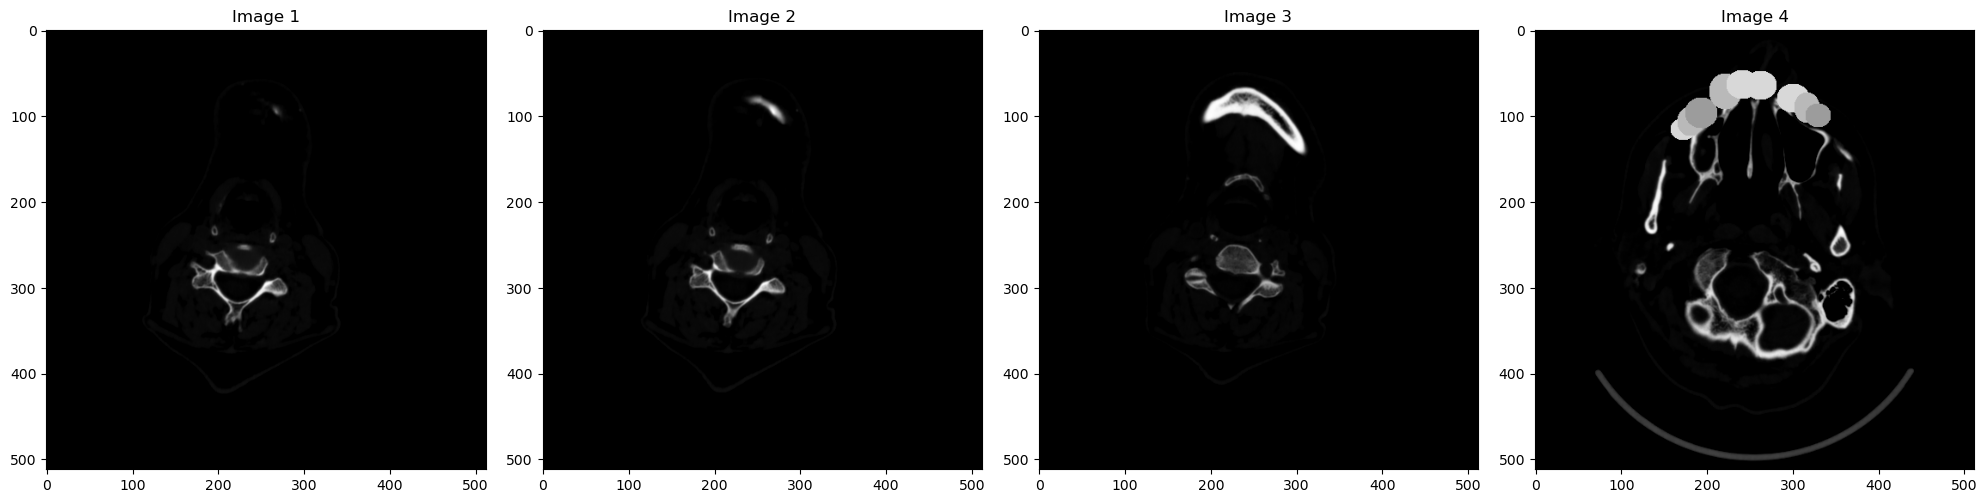

Labels:
study_uid: 1.2.643.5.1.13.13.12.2.77.8252.00001312020908070201120206020211
Radiology text report (in russian): На серии томограмм , выполненных в аксиальной плоскости с последующей мультипланарной реконструкцией с артефактами : На момент исследования убедительных данных за свежие зоны ишемии , ушибов и кровоизлияния не выявлено . ASPECTS 10 баллов . Обызвествления по межполушарной перегородке . Срединные структуры не смещены . Желудочки головного мозга умеренно расширены , боковые желудочки симметричны . Конвекситальные субарахноидальные пространства , Сильвиевы щели умеренно расширены . Цистерны основания мозга не деформированы . Турецкое седло в размерах не увеличено , объемных образований не содержит . Ствол , базальные отделы височнывх долей с артефактами . Мозжечок без особенностей . Глазодвигательные мышцы и зрительные нервы структурные.Ретробульбарная клетчатка не инфильтрирована . Свежих костно-травматических изменений достоверно не выявлено . Старый перелом костей носа

In [157]:
first_images, first_labels = train_dataset.__getitem__(0)

plot_dicom_images(first_images, first_labels)